# ***Get Data***

* Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from annoy import AnnoyIndex

* Get data

In [3]:
df = pd.read_csv('../data/test.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


* Lakukan pengecekan data yang missing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [5]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df_num = df[numeric_features].drop('Id', axis=1)

original_columns = list(df_num.columns)

print("--- Jumlah Missing Values SEBELUM Imputasi ---")
missing_values_before = df_num.isnull().sum()
print(missing_values_before[missing_values_before > 0].sort_values(ascending=False))

--- Jumlah Missing Values SEBELUM Imputasi ---
LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF1        1
BsmtFinSF2        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageCars        1
GarageArea        1
dtype: int64


* Lakukan imputasi pada data

In [6]:
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df_num)

df_imputed = pd.DataFrame(df_imputed, columns=original_columns)
print("Data berhasil di-imputasi.")
print(f"Jumlah NaN setelah imputasi: {df_imputed.isnull().sum().sum()}\n")

Data berhasil di-imputasi.
Jumlah NaN setelah imputasi: 0



In [7]:
df_imputed['TotalArea'] = df_imputed['GrLivArea'] + df_imputed['TotalBsmtSF']
print(f"Bentuk data setelah menambah fitur baru: {df_imputed.shape}\n")

Bentuk data setelah menambah fitur baru: (1459, 37)



In [8]:
selector = VarianceThreshold(threshold=0.0)
columns_before_variance_check = df_imputed.columns
df_variant = selector.fit_transform(df_imputed)

dropped_columns = columns_before_variance_check[~selector.get_support()]
if len(dropped_columns) > 0:
    print(f"Membuang {len(dropped_columns)} kolom dengan variasi nol:")
    print(list(dropped_columns))
else:
    print("Tidak ada kolom dengan variasi nol yang dibuang.")
print(f"Bentuk data setelah membuang variasi nol: {df_variant.shape}\n")

Tidak ada kolom dengan variasi nol yang dibuang.
Bentuk data setelah membuang variasi nol: (1459, 37)



* Lakukan pengecekan kembali untuk missing data

In [9]:
scaler = StandardScaler() #
X_scaled = scaler.fit_transform(df_variant)

print("--- Proses Preprocessing Selesai ---")
print(f"Bentuk akhir X_scaled (siap clustering): {X_scaled.shape}")
print(f"Jumlah NaN di data akhir (Cek final): {np.isnan(X_scaled).sum()}")

--- Proses Preprocessing Selesai ---
Bentuk akhir X_scaled (siap clustering): (1459, 37)
Jumlah NaN di data akhir (Cek final): 0


# ***Clustering***

* Melakukan penyiapan untuk K-Means & DBSCAN

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)

print(f"Contoh 10 label pertama: {labels_kmeans[:10]}")

dbscan = DBSCAN(eps=3.2, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_scaled)

print(f"Contoh 10 label pertama: {labels_dbscan[:10]}")

Contoh 10 label pertama: [4 4 3 3 2 3 2 3 2 4]
Contoh 10 label pertama: [ 2 -1  0  0 -1  0 -1  0 -1  2]


* Penghitungan Silhoute score dan Davis Bouldin score untuk K-Means dan DBSCAN

In [17]:
print('K-Means')
score_kmeans_sil = silhouette_score(X_scaled, labels_kmeans)
score_kmeans_db = davies_bouldin_score(X_scaled, labels_kmeans)
print(f'Silhoutte score: {score_kmeans_sil:.4f}')
print(f'Davies - bouldin: {score_kmeans_sil:.4f}')
print('DBSCAN')
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"DBSCAN menemukan {n_clusters_dbscan} cluster (tidak termasuk noise).")
if n_clusters_dbscan > 1:
    score_dbscan_sil = silhouette_score(X_scaled, labels_dbscan)
    score_dbscan_db = davies_bouldin_score(X_scaled, labels_dbscan)
    print(f"DBSCAN Silhouette Score: {score_dbscan_sil:.4f}")
    print(f"DBSCAN Davies-Bouldin Index: {score_dbscan_db:.4f}")
else:
    print("Not Found.")

K-Means
Silhoutte score: 0.1089
Davies - bouldin: 0.1089
DBSCAN
DBSCAN menemukan 4 cluster (tidak termasuk noise).
DBSCAN Silhouette Score: -0.0566
DBSCAN Davies-Bouldin Index: 2.7254


* Lakukan reduksi dimensi menggunakan 2D PCA

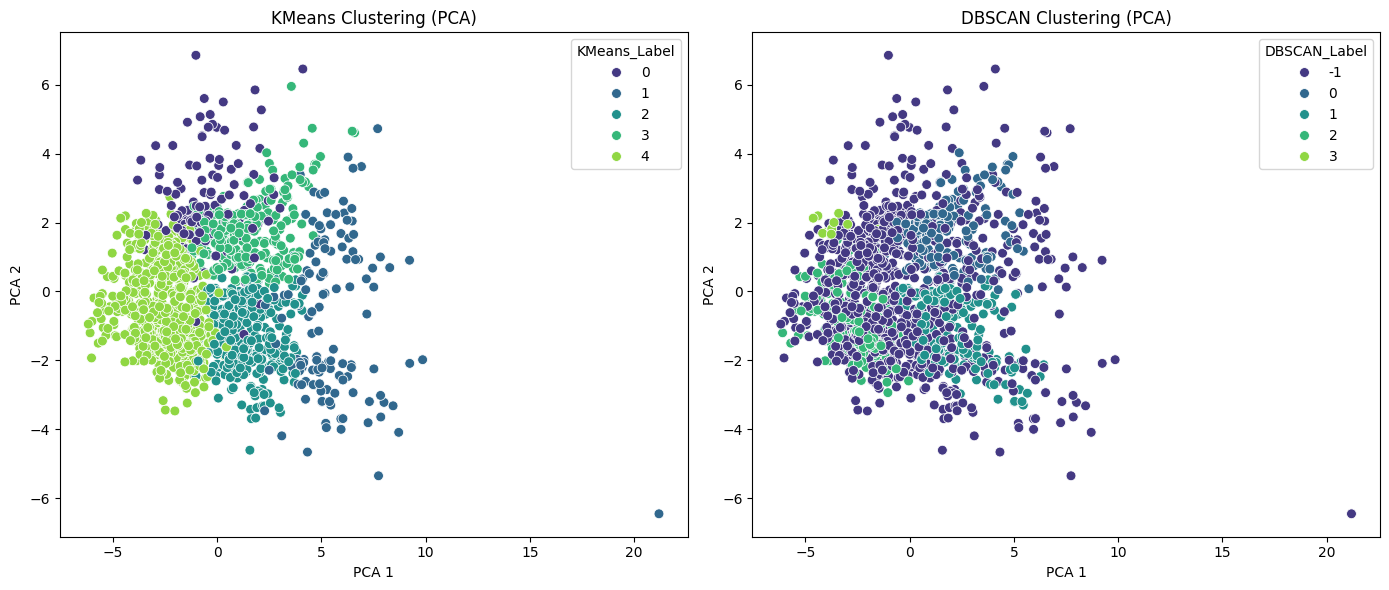

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_plot = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_plot['KMeans_Label'] = labels_kmeans
df_plot['DBSCAN_Label'] = labels_dbscan
df_plot['KMeans_Label'] = df_plot['KMeans_Label'].astype('category')
df_plot['DBSCAN_Label'] = df_plot['DBSCAN_Label'].astype('category')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='KMeans_Label', palette='viridis', legend='full', s=50) # s=50 untuk ukuran titik
plt.title('KMeans Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='DBSCAN_Label', palette='viridis', legend='full', s=50)
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()

# ***ANN Model***

In [14]:
dimensions = X_scaled.shape[1]
ann_index = AnnoyIndex(dimensions, 'euclidean')
print("Membangun indeks Annoy...")
for i in range(len(X_scaled)):
    ann_index.add_item(i, X_scaled[i])

ann_index.build(10)
print("Indeks Annoy berhasil dibangun.")
num_queries = 5
k_neighbors = 6

query_indices = np.random.choice(len(X_scaled), num_queries, replace=False)

print(f"\n--- Menjalankan {num_queries} Query Acak ---")

for query_idx in query_indices:

    neighbors, distances = ann_index.get_nns_by_item(query_idx, k_neighbors, include_distances=True)
    query_cluster = labels_kmeans[query_idx]

    print("\n=============================================")
    print(f"Hasil untuk Query Point [Index: {query_idx}]") #
    print(f"Titik ini ada di Cluster KMeans: {query_cluster}")
    print("---------------------------------------------")
    print("Tetangga Terdekat yang Ditemukan:") #

    for i in range(1, len(neighbors)):
        n_idx = neighbors[i]
        n_dist = distances[i]
        n_cluster = labels_kmeans[n_idx]

        print(f"  -> Index: {n_idx:<5} | Jarak: {n_dist:<.4f} | Cluster (KMeans): {n_cluster}") #

    print("=============================================")

Membangun indeks Annoy...
Indeks Annoy berhasil dibangun.

--- Menjalankan 5 Query Acak ---

Hasil untuk Query Point [Index: 527]
Titik ini ada di Cluster KMeans: 3
---------------------------------------------
Tetangga Terdekat yang Ditemukan:
  -> Index: 534   | Jarak: 1.4355 | Cluster (KMeans): 3
  -> Index: 411   | Jarak: 1.4682 | Cluster (KMeans): 3
  -> Index: 480   | Jarak: 1.7245 | Cluster (KMeans): 3
  -> Index: 224   | Jarak: 1.7555 | Cluster (KMeans): 3
  -> Index: 528   | Jarak: 1.7621 | Cluster (KMeans): 3

Hasil untuk Query Point [Index: 437]
Titik ini ada di Cluster KMeans: 4
---------------------------------------------
Tetangga Terdekat yang Ditemukan:
  -> Index: 87    | Jarak: 3.1207 | Cluster (KMeans): 4
  -> Index: 390   | Jarak: 3.7591 | Cluster (KMeans): 4
  -> Index: 690   | Jarak: 3.7622 | Cluster (KMeans): 4
  -> Index: 997   | Jarak: 3.8240 | Cluster (KMeans): 4
  -> Index: 352   | Jarak: 3.9808 | Cluster (KMeans): 4

Hasil untuk Query Point [Index: 1187]
Tit

# ***Kesimpulan***

1. Perbedaan antara model DBSCAN dan K-MEANS mana yang lebih baik menurut anda
    * Dari hasil kedua model ketika dilakukan penghitungan skor K-Means memiliki hasil yang lebih baik dibandingkan     DBSCAN sebagai aspek contoh pada silhoute score K-MEANS memiliki hasil yang lebih bagus yakni (0.1089) dibandingkan DBSCAN yang memiliki score (-0.0566), hal ini dikarenakan pada DBSCAN memiliki noise sehingga perhitungan menjadi kurang bagus.

2. Nilai metrik terbaik (Sillhoute dan DBI)
    * Sillhoute K-MEANS dengan score (0.1089)
    * DBI DBSCAN dengan score (2.7254)

3. Hasil Query: apakah tetangga yang ditemukan termasuk dalam cluster yang sama? Jelaskan jawaban anda.
    * Pada index 527 ditemukan tetangga dalam cluster yang sama yakni cluster 3
    * Pada index 459 ditemukan tetangga dalam cluster yang sama yakni cluster 2